# Customer Segmentation (RFM Clustering)

###### Summary:
Previously, we saw how to use open datasets and Cluster zipcodes/ DMAs into <b>targets where our customers reside.</b> Now, say we have sales data for our website, and want to <b>understand segments based on customer behavior on our website, purchasing and monetary patterns, we need to conduct our analysis on sales + website data.</b>

Hence, based on behavior, customers can be grouped into different targets/ buckets, and see what each of them means in a Business setting.

For each of the customer segment type, we might have to run <b>specific Ads to target segments, or maybe provide special offers to another.</b> RFM models are proven to work again and again, making it a perfect go-to starting point for most Businesses.

###### Index:
1) [Dataset Exploration](#1)

2) [Why are ranked lists not enough ? What is RFM ?](#2)

3) [Clustering R, F and M individually](#3)

4) [Medians and Quartiles](#4)

5) [Scoring, Interpretations & Strategies](#5)

## Dataset Exploration 

* To understand customer behavior, we analyze sales data of an E-commerce company based in the UK for a period of 8-months. We have the date, product description, quantity and price, along with the Customer ID, which can be used to look at the same customer across the 8-month timeframe.

<a id='1'></a>

In [2]:
# importing necessary libraries
# Dataset Source: https://www.kaggle.com/vijayuv/onlineretail

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# reading Online Retail file into DataFrame

df_retail1 = pd.read_excel('RFMOnlineRetail.xlsx')
df_retail1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


* Let us say we own this Online retail store, and are based off the UK. However, we provide delivery services across the globe, and do have customers from other countries purchasing our products as well. Let us take a look at the number of customers across countries.

In [3]:
np.seterr(divide = 'ignore')
# groupby country and getting customers
df_country_cust = df_retail1.groupby('Country').count()[['CustomerID']].reset_index()

# renaming columns
df_country_cust.columns = ['country', 'num_cust']

# sort by descending order of # of customers
df_country_cust = df_country_cust.sort_values('num_cust', ascending=False)

* From our dataset, we have the quantity and price per quantity, hence, we can calculate the total <strong>amount</strong> per order. Let us see top 20 countries which provided highest amounts aggregated across 8 months of data.

In [4]:
df_retail1['Amount'] = df_retail1['Quantity']*df_retail1['UnitPrice']
df_retail1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [5]:
# Aggregate and sum of Amount by country
df_country_agg_sales = df_retail1.groupby('Country').sum()[['Amount']].reset_index()

# sort in descending order by amount
df_country_agg_sales = df_country_agg_sales.sort_values('Amount',ascending=False)

Text(0.5, 1.0, 'Top 20 Countries by Aggregated Amount of sales across 8 month time-period')

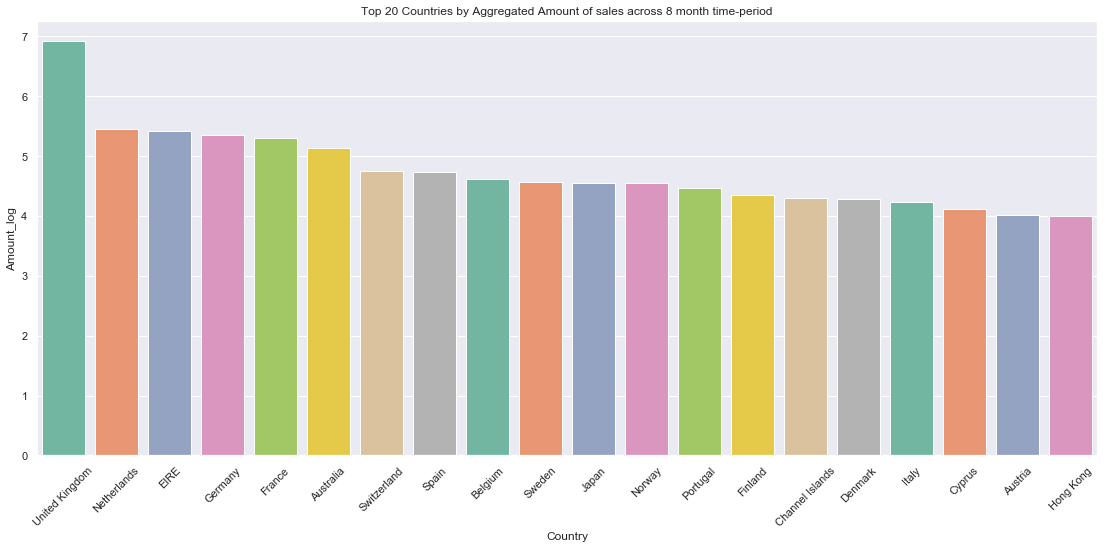

In [6]:
# apply log scale for easier viz
df_country_agg_sales['Amount_log'] = np.log10(df_country_agg_sales['Amount'])

plt.figure(figsize=(19,8))
sns.set(style="darkgrid")
plt.xticks(rotation=45)
sns.barplot(y='Amount_log', data=df_country_agg_sales.head(20), x='Country', palette='Set2')
plt.title('Top 20 Countries by Aggregated Amount of sales across 8 month time-period')

* From both plots, we observe that United Kingdom has highest number of customers and also generates highest sales amount aggregated across all time period. However, Netherlands has the 6th largest customer base, and contributes to second highest aggregated sales, which is interesting, and shows sale value per customer being higher for Netherlands over Germany, France, Spain and so on.


* Hence, it would also be good to calculate mean and median Amount spent per customer across countries, and potentially look at high value customer countries.

In [7]:
# sort by descending order of amount per country 
df_retail_mean_amt_country = df_retail1.groupby('Country').mean()[['Amount']].sort_values('Amount',ascending=False)
df_retail_mean_amt_country = df_retail_mean_amt_country.reset_index()

Text(0.5, 1.0, 'Top 20 Countries by Mean Amount of sales across 8 month time-period by Country')

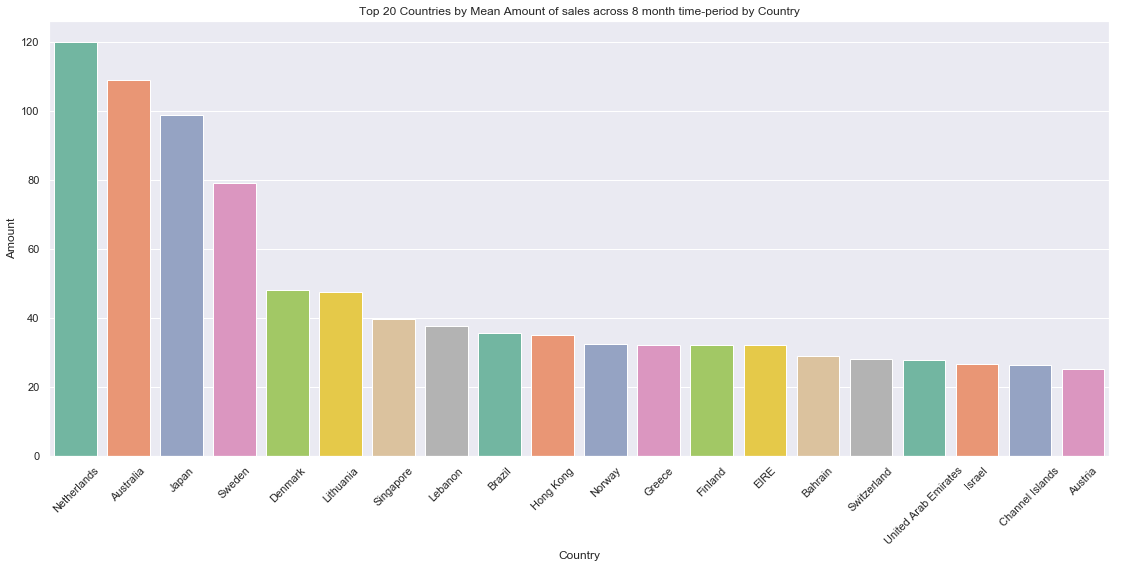

In [8]:
plt.figure(figsize=(19,8))
sns.set(style="darkgrid")
plt.xticks(rotation=45)
sns.barplot(y='Amount', data=df_retail_mean_amt_country.head(20), x='Country', palette='Set2')
plt.title('Top 20 Countries by Mean Amount of sales across 8 month time-period by Country')

* When we take the mean amount spent per custmer across 8 month time-frame, we find that United Kingdom is not even in the top 20. As suspected, Netherlands is on top of the chart with 120 (Mean Amount) spent per customer over 8 months.

## High-Value Customers 

* Given that we have the amount spent per order, and given that we know which customer made a specific order, we can calculate the total amount spent per customer, across 8-month time-period. By doing so, we can rank order the customers by descending order of that total aggregated amount across 8 months, and rank order them. Rank 1 indicates our highest valued customer, and decreases in value as the rank increases.

In [9]:
# groupby customerID and sum the amount

df_agg_cust = df_retail1.groupby('CustomerID').sum()[['Amount']].reset_index()
df_agg_cust.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# sort by descending Order
df_agg_cust = df_agg_cust.sort_values('Amount', ascending=False)

df_agg_cust['log_Amount'] = np.log10(df_agg_cust['Amount'])

# there are negative values which are cleaned
df_agg_cust = df_agg_cust[df_agg_cust.Amount >= 0]
# df_agg_cust['Amount'] = df_agg_cust['Amount'].astype('str')

# Ranking customers by absolute value

df_agg_cust['naive_rank'] = [i+1 for i in range(df_agg_cust.shape[0])]
df_agg_cust.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CustomerID,Amount,log_Amount,naive_rank
1703,14646.0,279489.02,5.446365,1
4233,18102.0,256438.49,5.408983,2
3758,17450.0,187482.17,5.272960,3
1895,14911.0,132572.62,5.122454,4
55,12415.0,123725.45,5.092459,5


Text(0.5, 1.0, 'Rank vs Log Total Amount')

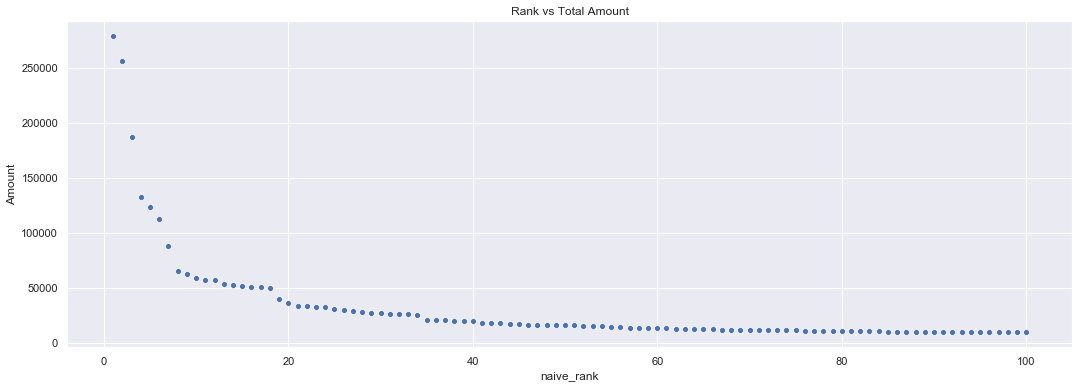

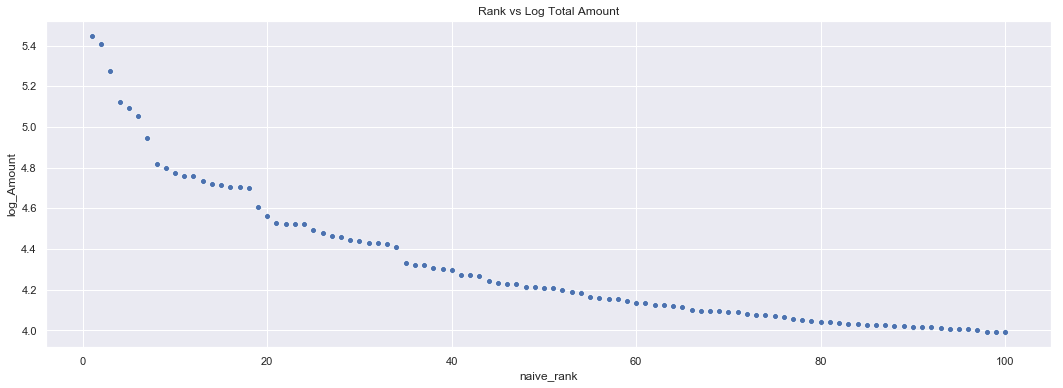

In [11]:
plt.figure(figsize=(18,6))
sns.scatterplot(x='naive_rank', y='Amount', data=df_agg_cust.head(100))
plt.title('Rank vs Total Amount')

plt.figure(figsize=(18,6))
sns.scatterplot(x='naive_rank', y='log_Amount', data=df_agg_cust.head(100))
plt.title('Rank vs Log Total Amount')

<a id='2'></a>
## What do we know till now ?

* From the above scatterplots, we observe the skew in Amount spent by rank order, and realize we have very few 'high value' customers based on visually inspecting customer sales information. However, our definition of 'high-value' is still naive, and only includes <strong>Absolute aggregated Monetary Value<strong> customers provide to us.

## RFM Model

* Our naive ranking system considers only monetary value into consideration. However, we can fetch other attributes from customers, so that we can dice them up into multiple clusters/ segments. 


* In our original dataset, we also have the date a product was purchased, along with the quantity ordered. We can also include <strong>Recency</strong> and <strong>Frequency</strong>, which can we used to segment users on how recent their last order was, along with the total number of orders placed (without the amount). Along with the high-value metric we calculated above, we lend ourselves to a traditional <strong>RFM Model</strong>.

#### What questions can be answered ?

* Do we have a lot of customers who we might have to retain ? 
* Is most of our customer base low-value and only few high valued ?
* Do we need to pay attention to people who we might lose ?
* Which Ad banner should we place or offer should we provide for people who are about to churn ?
* Do I need to incorporate all our customers in the next email campaign ?

These are few of the most common questions which need to be answered, but first, we need to segment our customers into buckets.

### Recency

* Given we have Invoice dates along with customerIDs, we can calculate the number of days since the last purchase, and can add it to the customer dataframe.

In [12]:
df_retail1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
Amount                float64
dtype: object

In [13]:
# take the most recent date for each customer, and merge with aggregate dataframe

df_agg_cust = df_agg_cust.merge(df_retail1.groupby('CustomerID').max()[['InvoiceDate']].reset_index(), on='CustomerID')

In [14]:
# Since the date of latest purchase across all customers, we calculate the difference with the invoiceDate for 
# ALL customers, to calculate recency

max_date = df_agg_cust.InvoiceDate.max()

df_agg_cust['Recency'] = df_agg_cust['InvoiceDate'].apply(lambda x: (max_date-x).days)

In [15]:
# dropping unnecessary columns and renaming others

df_agg_cust.drop(['log_Amount', 'naive_rank', 'InvoiceDate'], axis=1, inplace=True)
df_agg_cust.columns = ['CustomerID', 'Monetary', 'Recency']

### Frequency

* Total number of unique Invoices grouped by customer provides us the total frequency for each customer across 8-month timeframe. We combine this with the aggregated dataframe to obtain all the three attributes (R,F and M)

In [16]:
# combine dataframes, rename columns and change order to RFM

df_agg_cust = df_agg_cust.merge(df_retail1.groupby('CustomerID').count()[['InvoiceNo']].reset_index())
df_agg_cust.columns = ['CustomerID', 'Monetary', 'Recency', 'Frequency']
df_agg_cust = df_agg_cust[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

In [17]:
df_agg_cust.head()

,CustomerID,Recency,Frequency,Monetary
0,14646.0,1,2085,279489.02
1,18102.0,0,433,256438.49
2,17450.0,7,351,187482.17
3,14911.0,0,5903,132572.62
4,12415.0,23,778,123725.45


* Now that we have all three attributes, we can apply clustering algorithms to see if they provide us any insights.

(0, 20000)

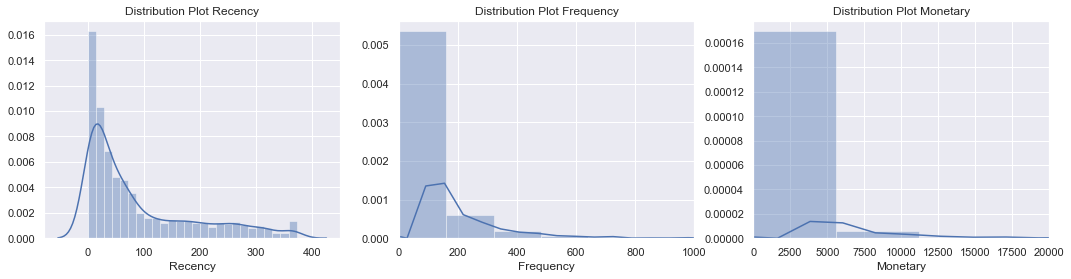

In [18]:
# Distributions
plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
sns.distplot(df_agg_cust.Recency)
plt.title('Distribution Plot Recency')

plt.subplot(1, 3, 2)
sns.distplot(df_agg_cust.Frequency)
plt.title('Distribution Plot Frequency')
plt.xlim(0,1000)

plt.subplot(1, 3, 3)
sns.distplot(df_agg_cust.Monetary)
plt.title('Distribution Plot Monetary')
plt.xlim(0,20000)

<a id='3'></a>
## K-Means

* For each of the above attributes, we apply K-means separately, and see for natural separation (In traditional marketing, quantiles are chosen and split into 4 groups across each attribute).


* However, we can also apply K-means to each of the attributes individually and re-assign labels back to the aggregated dataframe in a ranked order (might have to re-code cluster numbers as needed).

### Clustering Recency

In [19]:
# import Kmeans and silhouette metric

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

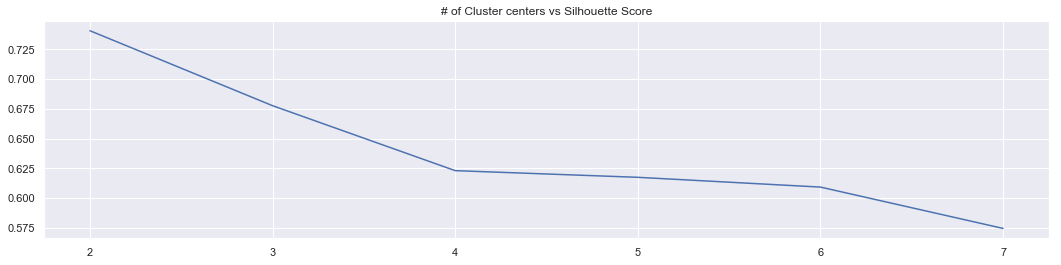

In [20]:
# first, we implement KMeans algorithm, for various k

#looping over different range of number of cluster centres
scores = []
for num_cluster in range(2,8):
    kmeans_silhouette = KMeans(n_clusters=num_cluster)
    kmeans_fit = kmeans_silhouette.fit(df_agg_cust[['Recency']])
    labels = kmeans_fit.labels_

    score = silhouette_score(df_agg_cust[['Recency']], labels)
    scores.append(score)

plt.figure(figsize=(18,4))
plt.title('# of Cluster centers vs Silhouette Score')
plt.plot(np.arange(2,8), scores)

* We observe that the silhouette distance steadily decreases after k=2, hence, we choose k as 2 for final assignment for recency.

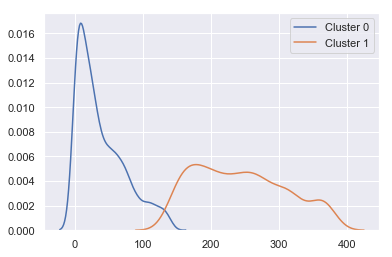

In [21]:
# fit best model and re-assign labels to original dataframe
kmeans_recency = KMeans(n_clusters=2, random_state=42)
kmeans_fit = kmeans_recency.fit(df_agg_cust[['Recency']])
labels = kmeans_fit.labels_
df_agg_cust['Recency_labels'] = labels

# KDE Plots for Cluster 0 and 1 (Recency)

sns.kdeplot(df_agg_cust[df_agg_cust.Recency_labels == 0].Recency, label='Cluster 0')
sns.kdeplot(df_agg_cust[df_agg_cust.Recency_labels == 1].Recency, label='Cluster 1')

* From the above KDE plot, we understand that Cluster 1 corresponds to the higher value of recency (meaning more number of days since last order), and Cluster 0 has lesser Recency (most recent), hence, the labels need to be interchanged.

In [22]:
# logical not to invert binary variables

df_agg_cust['Recency_labels'] = np.logical_not(df_agg_cust.Recency_labels).astype(int).tolist()

In [23]:
df_agg_cust.groupby('Recency_labels').mean()

,CustomerID,Recency,Frequency,Monetary
Recency_labels,,,,
0,15349.208098,244.274953,30.306026,507.198749
1,15282.263851,38.997245,114.595041,2379.752030


* Now that we flipped the labels, observe the mean Recency for Cluster 1 is lower, which is ideal, and cluster 0 is higher.

### Clustering Frequency

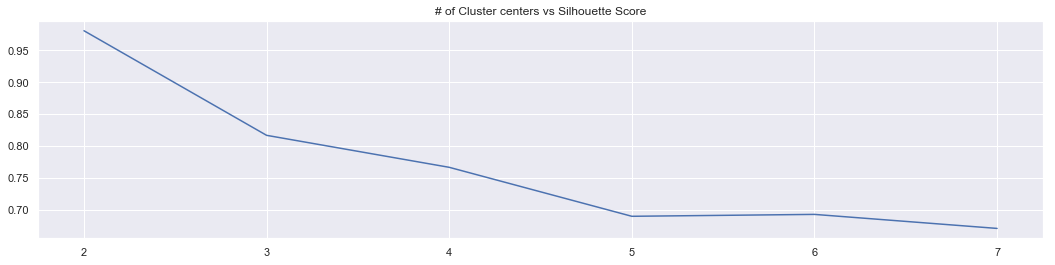

In [24]:
# first, we implement KMeans algorithm, for various k

#looping over different range of number of cluster centres
scores = []
for num_cluster in range(2,8):
    kmeans_silhouette = KMeans(n_clusters=num_cluster)
    kmeans_fit = kmeans_silhouette.fit(df_agg_cust[['Frequency']])
    labels = kmeans_fit.labels_

    score = silhouette_score(df_agg_cust[['Frequency']], labels)
    scores.append(score)

plt.figure(figsize=(18,4))
plt.title('# of Cluster centers vs Silhouette Score')
plt.plot(np.arange(2,8), scores)

* We observe that the silhouette distance steadily decreases after k=2, hence, we choose k as 2 for final assignment for Frequency.

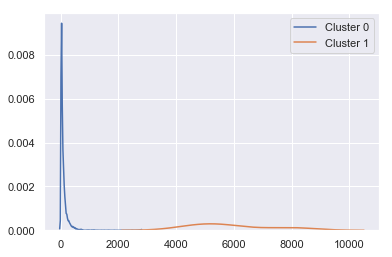

In [25]:
# fit best model and re-assign labels to original dataframe
kmeans_frequency = KMeans(n_clusters=2, random_state=42)
kmeans_fit = kmeans_frequency.fit(df_agg_cust[['Frequency']])
labels = kmeans_fit.labels_
df_agg_cust['Frequency_labels'] = labels

# KDE Plots for Cluster 0 and 1 (Frequency)

sns.kdeplot(df_agg_cust[df_agg_cust.Frequency_labels == 0].Frequency, label='Cluster 0')
sns.kdeplot(df_agg_cust[df_agg_cust.Frequency_labels == 1].Frequency, label='Cluster 1')

* Observing the above clusters for Frequency, we observe that the cluster numbers are semantically correctly assigned by default, where Cluster 1 shows higher frequency and cluster 0 has lower frequency of purchasing.

### Clustering Monetary attribute

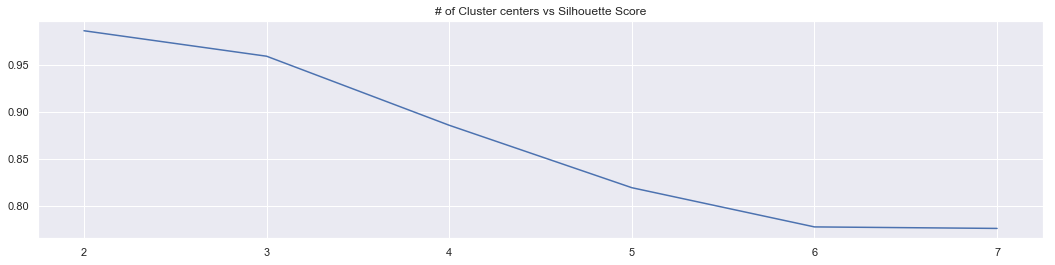

In [26]:
# first, we implement KMeans algorithm, for various k

#looping over different range of number of cluster centres
scores = []
for num_cluster in range(2,8):
    kmeans_silhouette = KMeans(n_clusters=num_cluster)
    kmeans_fit = kmeans_silhouette.fit(df_agg_cust[['Monetary']])
    labels = kmeans_fit.labels_

    score = silhouette_score(df_agg_cust[['Monetary']], labels)
    scores.append(score)

plt.figure(figsize=(18,4))
plt.title('# of Cluster centers vs Silhouette Score')
plt.plot(np.arange(2,8), scores)

* We observe that the silhouette distance steadily decreases after k=2, hence, we choose k as 2 for final assignment for Monetary attribute as well.

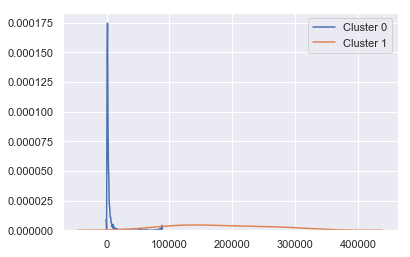

In [27]:
# fit best model and re-assign labels to original dataframe
kmeans_monetary = KMeans(n_clusters=2, random_state=42)
kmeans_fit = kmeans_monetary.fit(df_agg_cust[['Monetary']])
labels = kmeans_fit.labels_
df_agg_cust['Monetary_labels'] = labels

# KDE Plots for Cluster 0 and 1 (Monetary)

sns.kdeplot(df_agg_cust[df_agg_cust.Monetary_labels == 0].Monetary, label='Cluster 0')
sns.kdeplot(df_agg_cust[df_agg_cust.Monetary_labels == 1].Monetary, label='Cluster 1')

<a id='4'></a>

## Medians and Quartiles

* Similar to the Frequency labels, semantically, Cluster 1 and Cluster 0 have been assigned correctly. However, looking at the number of labels for Frequency and Monetary attributes, we observe that they do not form natural clusters, and Cluster 1 are rather outliers, and not a true cluster.


* However, recency label forms natural clusters; Hence, for other two attributes, we can use quartiles and label them accordingly. However, we need to explore and visualize if we can break them into quartiles or into two or three clusters/ segments.

In [28]:
# R forms natural clusters
df_agg_cust.Recency_labels.value_counts()

1    3267
0    1062
Name: Recency_labels, dtype: int64

In [29]:
# F does not form natural clusters
df_agg_cust.Frequency_labels.value_counts()

0    4325
1       4
Name: Frequency_labels, dtype: int64

In [30]:
# M does not form natural clusters
df_agg_cust.Monetary_labels.value_counts()

0    4323
1       6
Name: Monetary_labels, dtype: int64

In [31]:
# dropping labels
df_agg_cust.drop(['Frequency_labels', 'Monetary_labels'], inplace=True, axis=1)

* For simplicity, let us split both Frequency and Monetary attributes by median and not quartiles. Either can be chosen, depends on the range and distributions.

In [32]:
freq_cutoff = df_agg_cust.Frequency.median()
monetary_cutoff = df_agg_cust.Monetary.median()

freq_cutoff, monetary_cutoff

(42.0, 656.6800000000002)

In [33]:
# new labels for FM attributes
Frequency_labels = []
Monetary_labels = []

# if less than median, label as 0, else 1
for i in range(0,len(df_agg_cust)):
    if df_agg_cust.iloc[i].Frequency <= freq_cutoff:
        Frequency_labels.append(0)
    else:
        Frequency_labels.append(1)
        
    if df_agg_cust.iloc[i].Monetary <= monetary_cutoff:
        Monetary_labels.append(0)
    else:
        Monetary_labels.append(1)
        
# include labels in aggregated dataframe

df_agg_cust['Frequency_labels'] = Frequency_labels
df_agg_cust['Monetary_labels'] = Monetary_labels

df_agg_cust.head()

,CustomerID,Recency,Frequency,Monetary,Recency_labels,Frequency_labels,Monetary_labels
0,14646.0,1,2085,279489.02,1,1,1
1,18102.0,0,433,256438.49,1,1,1
2,17450.0,7,351,187482.17,1,1,1
3,14911.0,0,5903,132572.62,1,1,1
4,12415.0,23,778,123725.45,1,1,1


<a id='5'></a>

## Scoring & Interpretation

* From the RFM segments, we now have 4 clusters across 3 variables, which can be combined to form a final 'Score' which incorporates all the three attributes (R, F and M).

In [34]:
df_agg_cust['Score'] = df_agg_cust['Recency_labels'] + df_agg_cust['Frequency_labels'] + df_agg_cust['Monetary_labels']

df_agg_cust.Score.value_counts()

3    1666
1    1165
0     784
2     714
Name: Score, dtype: int64

* We have good number of customers in each of the segments. The score ranging from 0 to 3, increases in order of 'value' they can provide us. Hence, each of these segments needs to be catered to differently, right from loyalty programs, to providing discounts or heavy marketing to groups which are likely to leave. 


* We also observe that our 'best' cluster, also has most number of customers; we can split it down further into more groups as needed. Before we explore which marketing strategies could be better for which customer segment, let us analyze the clusters/ segments.

In [35]:
df_agg_cust.groupby('Score').mean()[['Recency', 'Frequency', 'Monetary']]

,Recency,Frequency,Monetary
Score,,,
0,250.613520,15.767857,266.301020
1,77.312446,22.578541,387.429547
2,73.173669,59.953782,1081.237228
3,28.828331,195.134454,4130.345829


## Segment Interpretations

* From the above aggregation table, we see that Customers with Score 0, have the highest Recency, least Frequency and least Monetary values, making them low-value customers; This group probably has <strong>one-time users<strong>, and also users who were <strong>once high-value, are now low-value customers<strong> (combination of actual low-value and customser who were mid/high-value before).


* We also see customers with Score 3, who are a part of the <strong>high-value</strong> customer base we have. This segment probably has <strong>new-comers</strong> who keep purchasing and even <strong>old-loyal customers</strong>. We might need to provide loyalty programs to few customers within this segment based on Recency alone. Hence, we can further split this into different groups as needed for better granularity.


* Segments with Scores 1 and 2 are similar in <strong>Recency</strong>, however, very different in Monetary and Frequency. We observe that the ratio of Frequency and Monetary attributes for Segment with Scores 1 and 2 are very different, with Monetary attribute being the most skewed. Hence, customers with Score 2 make <strong>costlier purchases</strong>, when compared to customers from Score 1.

<hr>


## Marketing Strategies for Segments

From source [RFM analysis for Customer Segmentation](https://clevertap.com/blog/rfm-analysis/) & [RFM Segmentation](https://www.putler.com/rfm-analysis/), we can breakdown our customers into the following segments.



### Champions

Highest value customers who purchased recently, frequently, with high Monetary value. Generally speaking, these customers are more likely to also try new products/ releases, and are also promoters of brand. Promotional offers have the best hit-ratio with these customers. For example, Grubhub might provide refer-a-friend promotional coupons to high-usage consumers; as they have high-propensity to spread their brand in their personal circles.

Beta versions can be easily tested for quick feedback, new product releases can be pushed over to our champions group, as they tend to be more responsive to our efforts.


### Loyalists

Customers falling in this segment